In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../"))
print(os.listdir("../input"))
print(os.listdir("../working"))

# Any results you write to the current directory are saved as output.

['src', 'lib', 'input', 'working']
['sample_submission.csv', 'train.csv', 'test.csv', 'train_images', 'test_images']
['__output__.json', '__notebook__.ipynb']


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import fastai
from fastai import vision
from fastai import widgets as util

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

fastai.core.defaults.device = torch.device(device)

if device == 'cuda':
    torch.backends.cudnn.deterministic = True
    vision.torch.backends.cudnn.benchmark = True

device: cuda


In [5]:
path = vision.Path("../input")
path

PosixPath('../input')

In [6]:
path.ls()

[PosixPath('../input/sample_submission.csv'),
 PosixPath('../input/train.csv'),
 PosixPath('../input/test.csv'),
 PosixPath('../input/train_images'),
 PosixPath('../input/test_images')]

In [7]:
!head -n 5 ../input/train.csv

id_code,diagnosis
000c1434d8d7,2
001639a390f0,4
0024cdab0c1e,1
002c21358ce6,0


In [8]:
train_df = vision.pd.read_csv(path/'train.csv')
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [9]:
# (path/'train_images').ls()

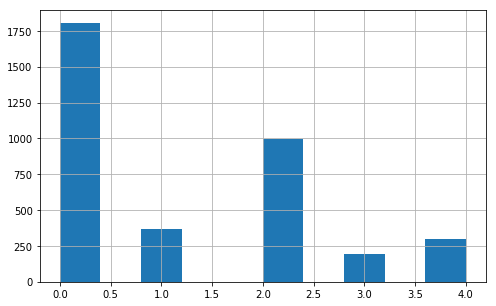

In [10]:
train_df['diagnosis'].hist(figsize = (8, 5))

In [11]:
def reduce_excess_image(df, frac=0.3):
    np.random.seed(1)
    df_zero = df[df['diagnosis'] == 0].sample(frac=(1 - frac))
    df_non_zero = df[df['diagnosis'] != 0]
    df = vision.pd.concat([df_zero, df_non_zero])
    df.sample(frac=1.)
    return df

train_df = reduce_excess_image(train_df)

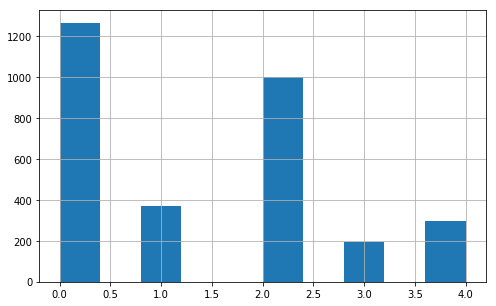

In [12]:
train_df['diagnosis'].hist(figsize = (8, 5))

In [13]:
train_data = vision.ImageDataBunch.from_df(path, df=train_df, folder='train_images', suffix = '.png',
                                           test = 'test_images', ds_tfms = vision.get_transforms(flip_vert=True, max_rotate=90.0),
                                           size=128, bs=32, seed=999).normalize(vision.imagenet_stats)

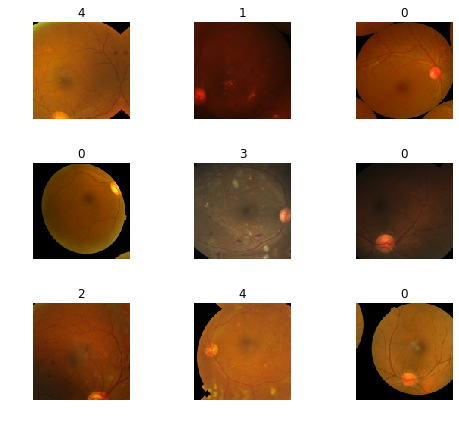

In [14]:
train_data.show_batch(3, figsize=(7, 6))

In [15]:
train_data.classes

[0, 1, 2, 3, 4]

In [16]:
learner = vision.learner.cnn_learner(train_data, 
                                     vision.models.resnet101, custom_head=None, bn_final=False, 
                                     metrics=vision.accuracy).to_fp32()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 83008735.77it/s]


In [17]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [18]:
learner.model_dir = '../working'
learner.model_dir

'../working'

In [19]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-03
Min loss divided by 10: 1.20E-02


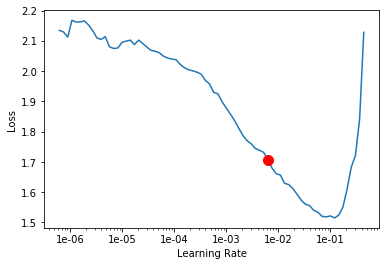

In [20]:
learner.recorder.plot(suggestion=True)

In [21]:
max_lr = 1e-2 / 2.
learner.fit_one_cycle(cyc_len=5, max_lr=max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.093007,0.847265,0.681090,07:08
1,0.875235,0.852842,0.722756,07:09
2,0.762557,0.791267,0.679487,07:09
3,0.677720,0.618678,0.777244,07:13
4,0.624136,0.611708,0.769231,07:09


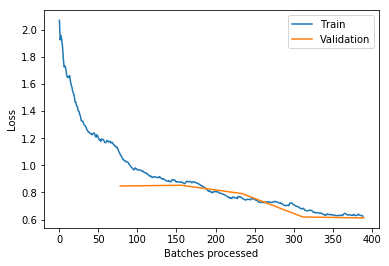

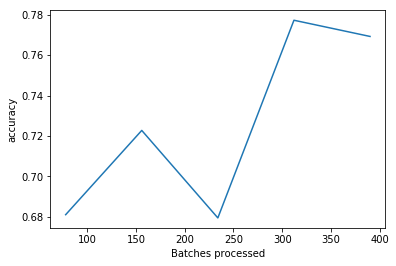

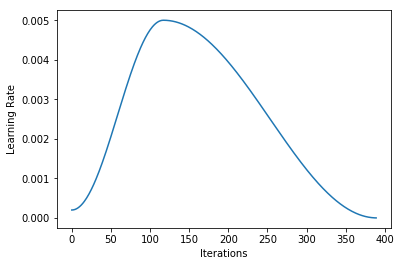

In [22]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()
learner.recorder.plot_lr()

In [23]:
learner.save('inp_128_freeze_epoch_5')

In [24]:
train_data = vision.ImageDataBunch.from_df(path, df=train_df, folder='train_images', suffix = '.png',
                                           test = 'test_images', ds_tfms = vision.get_transforms(flip_vert=True, max_rotate=90.0),
                                           size=224, bs=32, seed=999).normalize(vision.imagenet_stats)

learner = vision.learner.cnn_learner(train_data, 
                                     vision.models.resnet101, custom_head=None, bn_final=False, 
                                     metrics=vision.accuracy).to_fp32()

learner.model_dir = '../working'

learner.load('inp_128_freeze_epoch_5')

learner.model_dir

'../working'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 6.31E-08


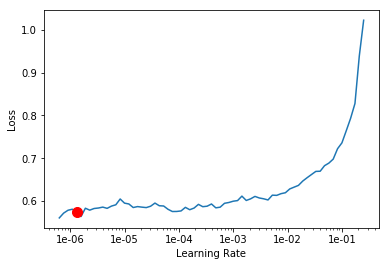

In [25]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [26]:
lr_range = slice(3e-6, 3e-4)
learner.fit_one_cycle(cyc_len=5, max_lr=lr_range)

epoch,train_loss,valid_loss,accuracy,time
0,0.611210,0.585952,0.786859,07:27
1,0.589307,0.568575,0.783654,07:22
2,0.599601,0.557831,0.798077,07:23
3,0.576751,0.546069,0.799679,07:22
4,0.573321,0.548044,0.796474,07:22


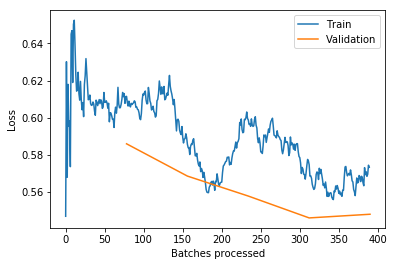

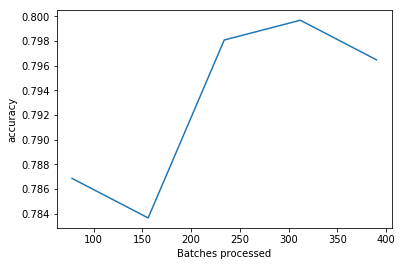

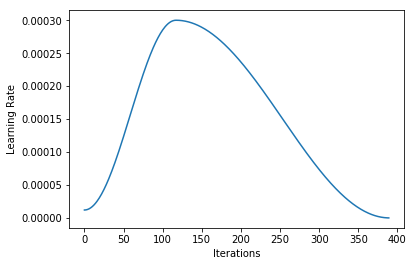

In [27]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()
learner.recorder.plot_lr()

In [28]:
learner.save('inp_224_freeze_epoch_5')

In [29]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-05
Min loss divided by 10: 6.31E-08


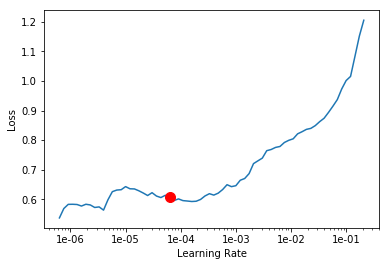

In [30]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [31]:
lr_range = slice(1e-6,1e-4)
learner.fit_one_cycle(cyc_len=5, max_lr=lr_range)

epoch,train_loss,valid_loss,accuracy,time
0,0.576384,0.538534,0.798077,07:34
1,0.564592,0.550920,0.790064,07:32
2,0.542478,0.531521,0.796474,07:34
3,0.533988,0.528585,0.798077,07:32
4,0.521318,0.535078,0.791667,07:33


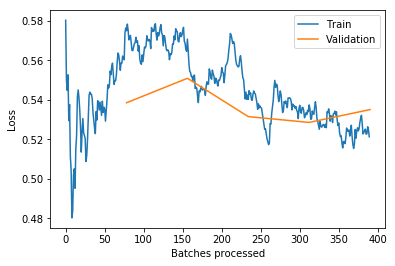

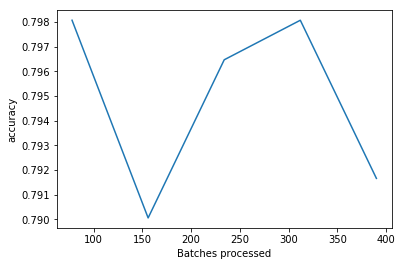

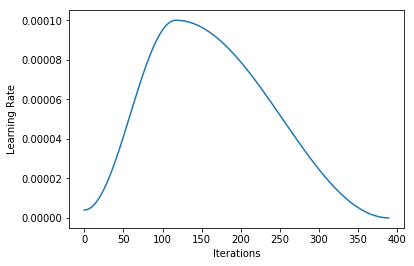

In [32]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()
learner.recorder.plot_lr()

In [33]:
learner.save('inp_224_unfreeze_epoch_5')

In [34]:
# pred, y_pred = learner.get_preds(ds_type = vision.DatasetType.Test)
# y_pred = y_pred.numpy()
# print(len(y_pred))

pred_tta, y_pred_tta = learner.TTA(ds_type = vision.DatasetType.Test)
y_pred_tta = y_pred_tta.numpy()
print(len(y_pred_tta))


1928


In [35]:
test_df = vision.pd.read_csv(path/'test.csv')
ss_df = vision.pd.read_csv(path/'sample_submission.csv')
test_df.shape, ss_df.shape, len(os.listdir('../input/test_images'))

((1928, 1), (1928, 2), 1928)

In [36]:
(test_df['id_code'] == ss_df['id_code']).all()

True

In [37]:
ss_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [38]:
ss_df['diagnosis'] = y_pred_tta.astype(int)
ss_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [39]:
ss_df.to_csv('submission.csv',index=False)